# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [16]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import GridSearchCV
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from prettytable import PrettyTable

from sklearn.cluster import AgglomerativeClustering , DBSCAN
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 4000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (4000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(3989, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.725

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(3989, 10)


1    3328
0     661
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████| 3989/3989 [00:01<00:00, 2431.56it/s]


In [20]:
preprocessed_reviews[1500]

'please ignore one star comments check bag main ingredient fact whole grain brown rice second rice flower anything gluten free add another binder corn flour comes someone celiac disease cannot sunchips contain wheat key binder chip cookie cereal excellent product spouse buy lot gluten free absolutely delicious'

# [4] Featurization

In [21]:
x = preprocessed_reviews
#y = final["Score"].values

## [4.1] BAG OF WORDS

In [19]:
#BoW
count_vect = CountVectorizer(max_features=5000) #in scikit-learn
count_vect.fit(x)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_x = count_vect.transform(x)

print("the type of count vectorizer ",type(bow_x))
print("the shape of out text BOW vectorizer ",bow_x.get_shape())
print("the number of unique words ", bow_x.get_shape()[1])


some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abundant', 'acacia', 'academy', 'acai']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 5000)
the number of unique words  5000


## [4.2] TF-IDF

In [20]:
# TFIDF using scikit-learn

tf_idf = TfidfVectorizer(max_features=5000) #arguments: ngram_range=(1,2), min_df=10                #in scikit-learn
tf_idf.fit(x)
print("some sample features",tf_idf.get_feature_names()[0:10])
print('='*50)

# we use fit() method to learn the vocabulary from x_train 
# and now transform text data to vectors using transform() method

tf_x = tf_idf.transform(x)


print("the type of count vectorizer ",type(tf_x))
print("the shape of out text BOW vectorizer ",tf_x.get_shape())
print("the number of unique words ", tf_x.get_shape()[1])


some sample features ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abundant', 'acacia', 'academy', 'acai']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 5000)
the number of unique words  5000


## [4.3] Word2Vec

In [22]:
# Train your own Word2Vec model using your own text corpus
list_of_sentance =[]

for sentance in x:
    list_of_sentance.append(sentance.split())

In [23]:
# this line of code trains your w2v model on the give list of sentances
w2v_model = Word2Vec(list_of_sentance, min_count=5, size=50, workers=-1)

In [24]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3295
sample words  ['used', 'ca', 'not', 'beat', 'great', 'product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'everybody', 'asks', 'bought', 'made', 'two']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

transforming data

In [25]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
print(sent_vectors.shape)
print(sent_vectors[0])

100%|█████████████████████████████████████████| 3989/3989 [00:03<00:00, 1176.55it/s]


(3989, 50)
[ 5.99672281e-04  7.64636330e-04 -2.29854094e-03  2.44301589e-03
 -2.09817954e-03 -3.38831730e-03  2.82283415e-03 -6.90904029e-04
 -2.20035207e-03 -2.55433971e-03  3.29615991e-03  1.31964059e-03
  1.10778965e-03  2.11975407e-03  1.44524877e-03 -1.10130808e-03
 -1.29601793e-03  4.80755748e-03 -3.80111014e-05 -2.73051968e-03
  3.07025310e-03 -6.51911118e-03 -1.87149072e-03  6.95889238e-04
 -2.59450291e-03 -1.82195580e-03  8.75526350e-04  2.76595549e-03
 -2.72752027e-03  5.45621004e-03  5.87445335e-04  3.44362975e-03
 -2.02620336e-03  1.68601134e-03 -1.60853390e-03 -6.06450314e-03
 -2.38348193e-03 -5.37604711e-03 -3.86534569e-04  3.21779764e-03
  1.15747719e-03  6.49153228e-04  1.72706635e-03  1.76951184e-03
 -4.34946269e-05  4.51509565e-03  1.86463861e-03 -2.14838911e-03
 -2.44446343e-03 -5.04625496e-05]


#### [4.3.1.2] TFIDF weighted W2v

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

converting train data

In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████| 3989/3989 [00:18<00:00, 217.66it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [27]:
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(bow_x)
    loss.append(kmeans.inertia_)

Elbow Method

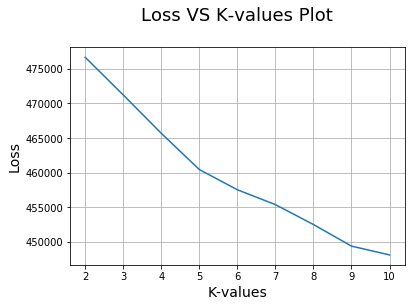

In [28]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [29]:
optimal_k = 5
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(bow_x)

In [30]:
reviews = final['CleanedText'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))        

No. of reviews in Cluster-1 :  2284

No. of reviews in Cluster-2 :  170

No. of reviews in Cluster-3 :  6370

No. of reviews in Cluster-4 :  363

No. of reviews in Cluster-5 :  377


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [31]:
#https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/KMeansClustering_amazon_food_review.ipynb

#Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(5, 3, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

5


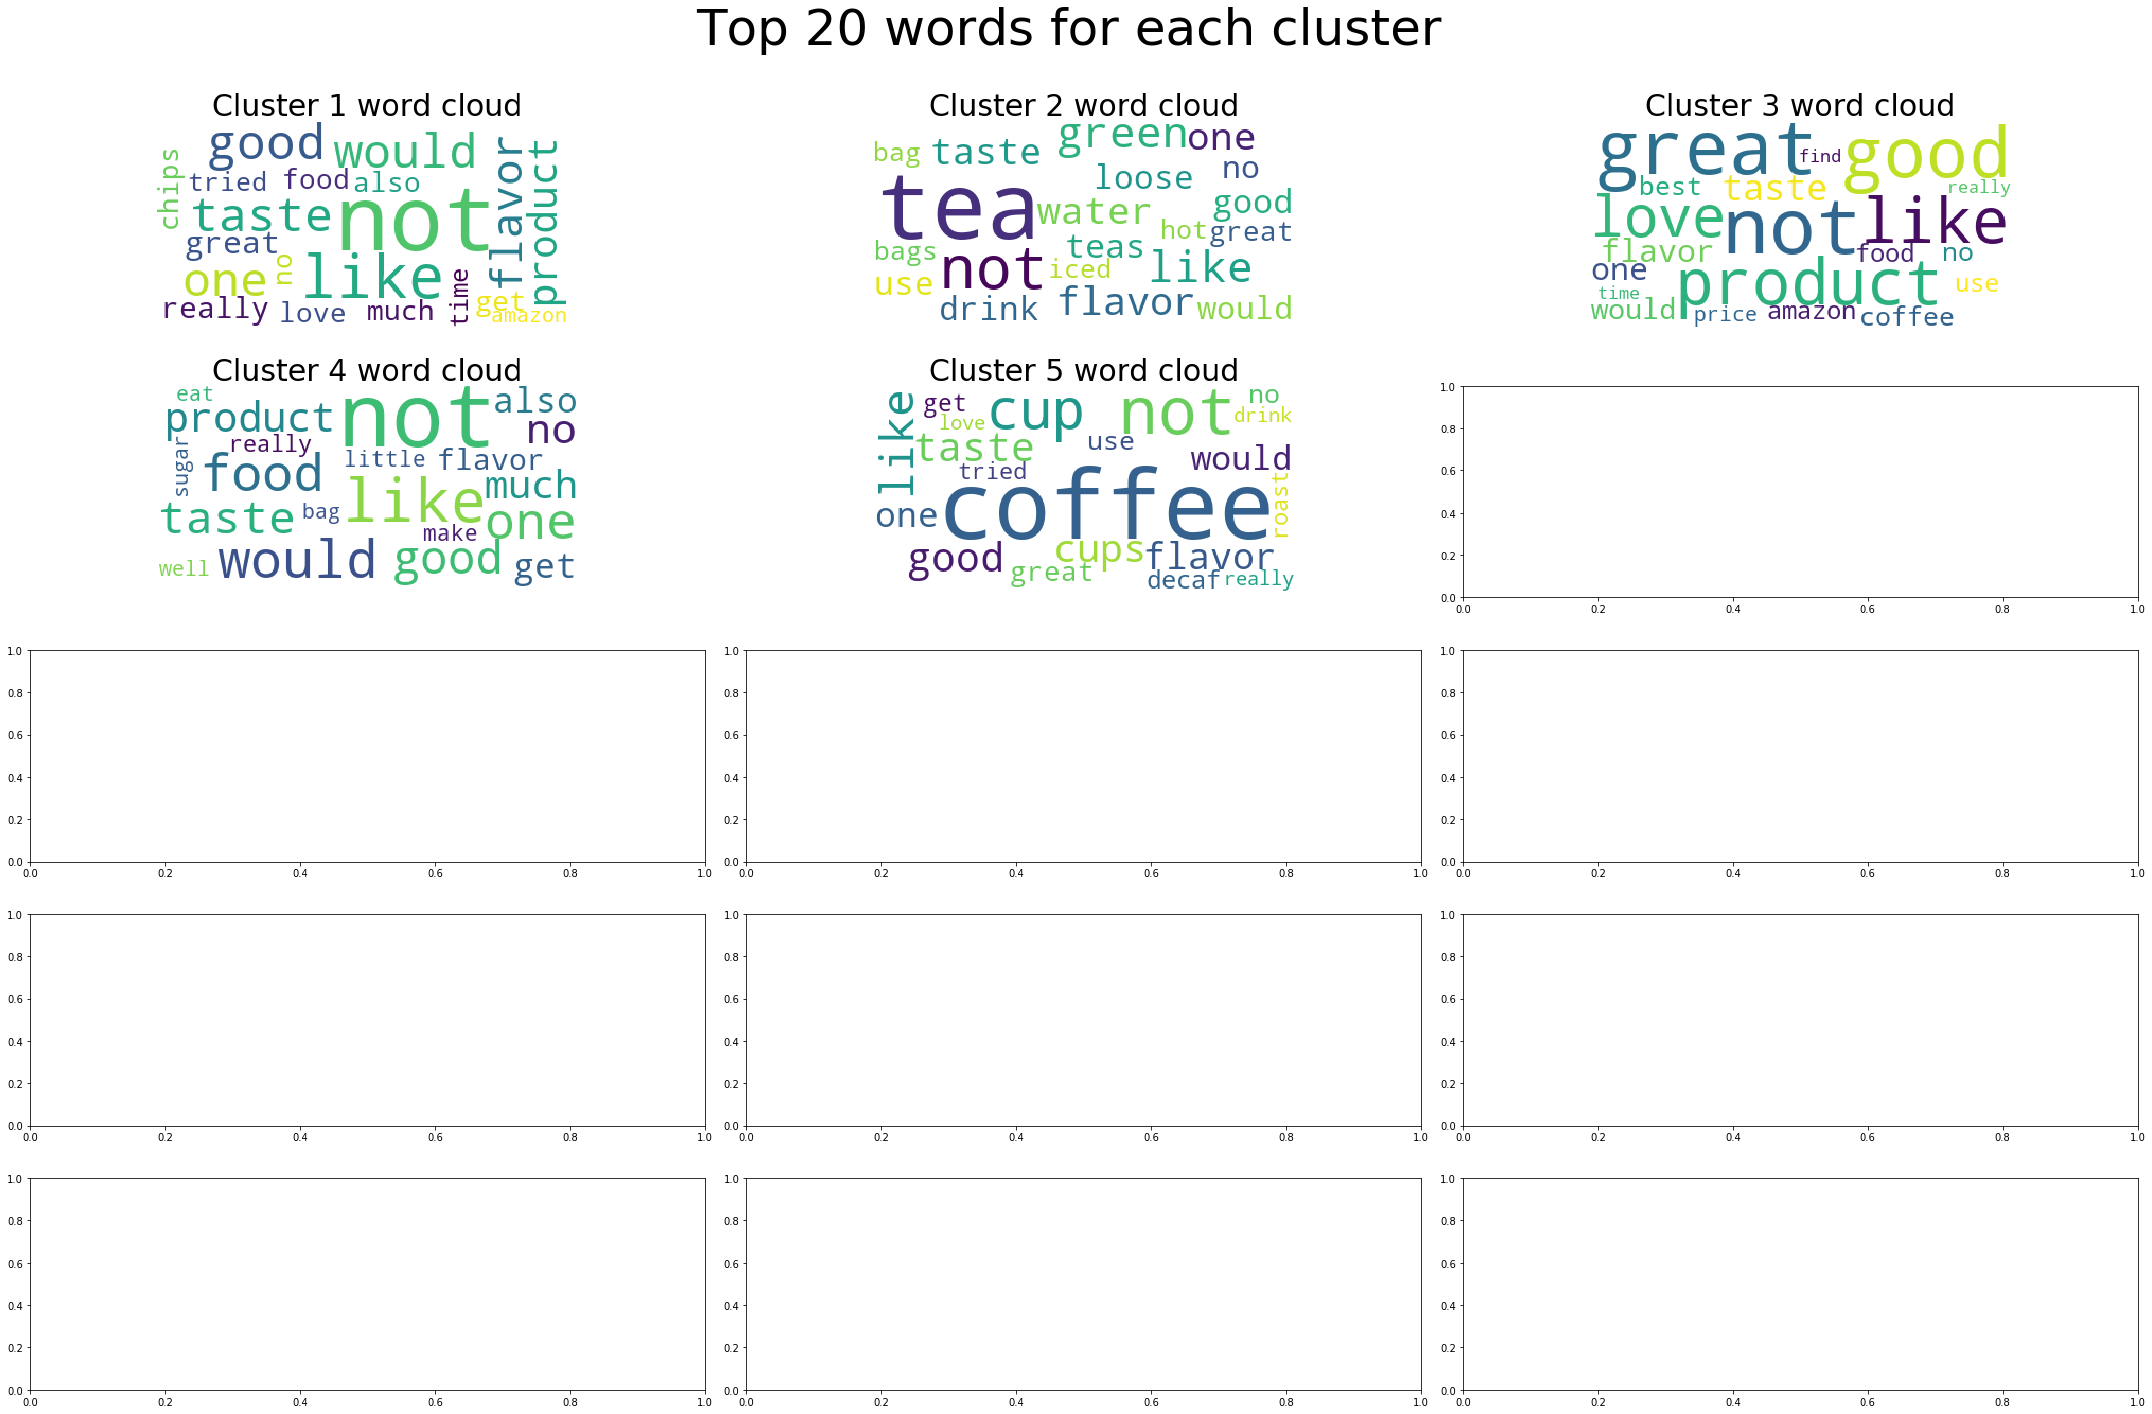

In [35]:
# getting feature names in features 
# and the cluster centers in coef
# Plot the all cluster with their corresponding features
features = count_vect.get_feature_names()
coef = kmeans.cluster_centers_
plot_cluster_cloud(features, coef)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [36]:
k_values = [2,3,4,5,6,7,8]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(tf_x)
    loss.append(kmeans.inertia_)

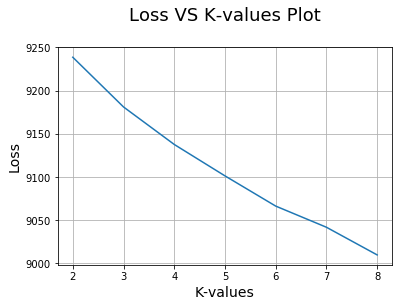

In [37]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [38]:
optimal_k = 6
# Variable that will be used in the conclusion 
tf_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(tf_x)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    else :
        cluster6.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))

No. of reviews in Cluster-1 :  471

No. of reviews in Cluster-2 :  974

No. of reviews in Cluster-3 :  641

No. of reviews in Cluster-4 :  446

No. of reviews in Cluster-5 :  495

No. of reviews in Cluster-6 :  6537


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

6


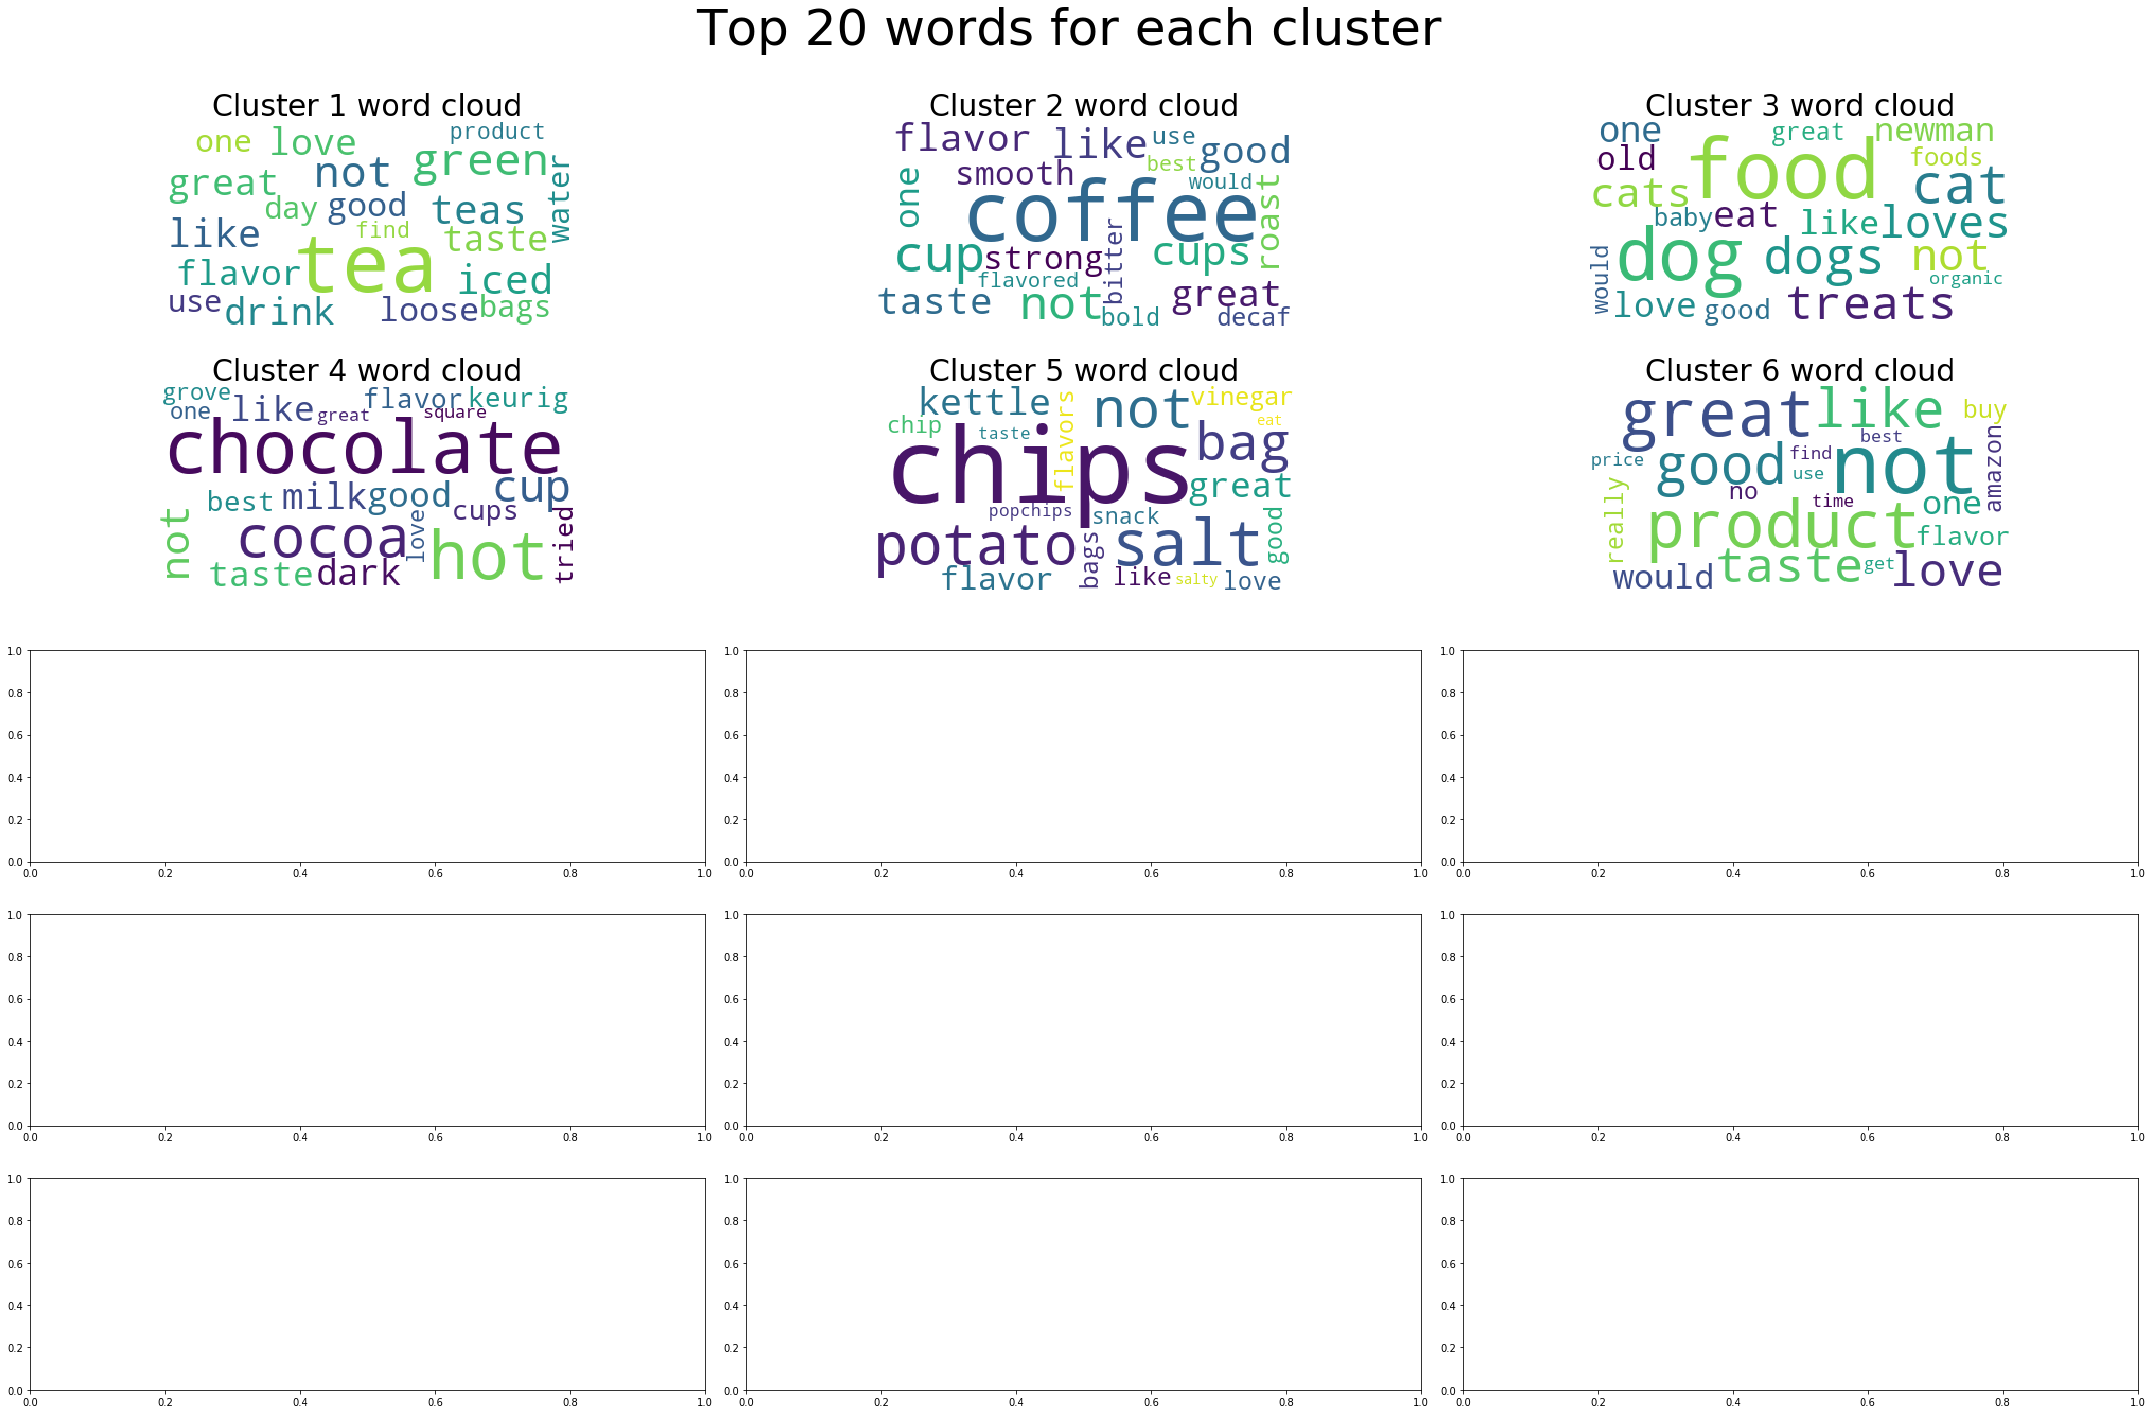

In [40]:
# #https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/KMeansClustering_amazon_food_review.ipynb
# getting feature names in features 
# and the cluster centers in coef
# Plot the all cluster with their corresponding features
features = count_vect.get_feature_names()
coef = kmeans.cluster_centers_
plot_cluster_cloud(features, coef)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [41]:
k_values = [2,3,4,5,6,7,8]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(sent_vectors)
    loss.append(kmeans.inertia_)

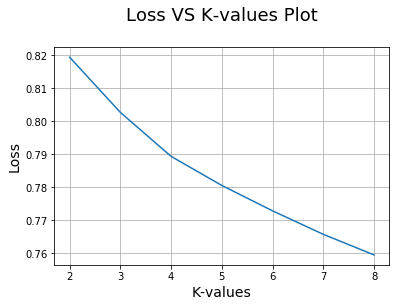

In [42]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [45]:
sent_vectors.shape

(9564, 50)

In [43]:
optimal_k = 4
# Variable that will be used in the conclusion 
avg_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(sent_vectors)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  2606

No. of reviews in Cluster-2 :  1261

No. of reviews in Cluster-3 :  3308

No. of reviews in Cluster-4 :  2389


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [123]:
def plot_word_cloud(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    cloud
    # Remove duplicate words
    stopwords = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of top words")
    plt.tight_layout(pad = 0)
  
    plt.show()

In [95]:
# https://github.com/premvardhan/Amazon-fine-food-review-analysis/blob/master/KMeansClustering_amazon_food_review.ipynb
# Assign each review to its cluster label
# i.e. Which review belongs to which cluster
final["cluster_label"] = kmeans.labels_
final["CleanedText"] = preprocessed_reviews

Total number of review in cluster 1 is: 2606


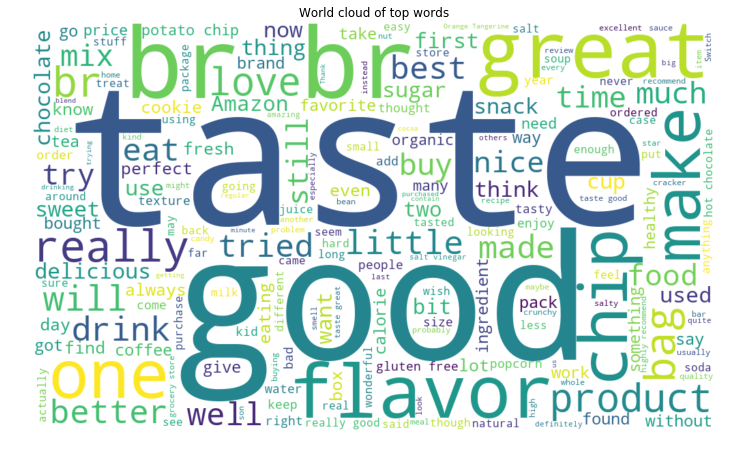

Total number of review in cluster 2 is: 1261


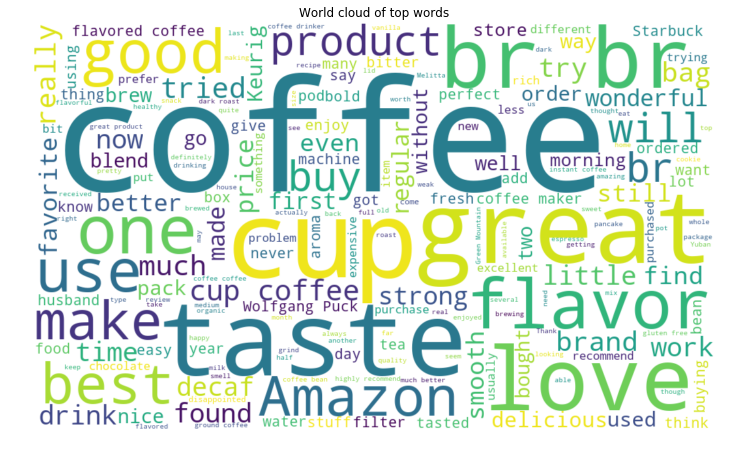

Total number of review in cluster 3 is: 3308


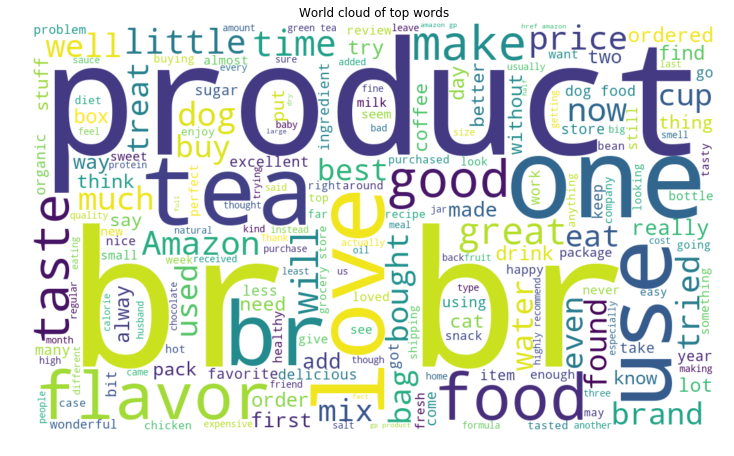

Total number of review in cluster 4 is: 2389


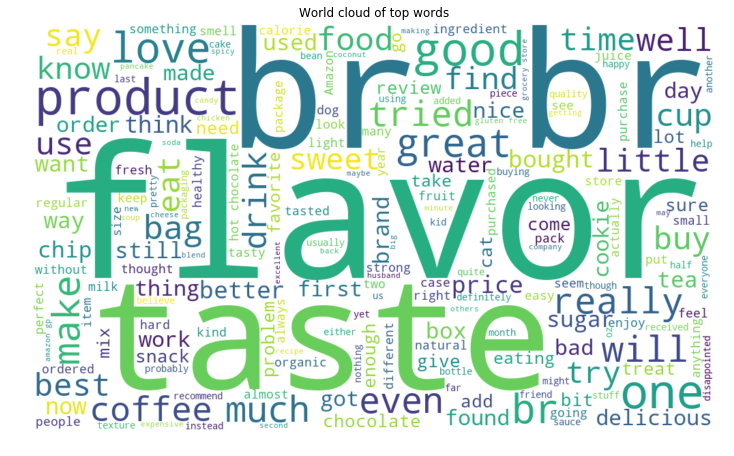

In [59]:
# For each cluster, group with its corresponding label.
for i in range(kmeans.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
   
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["CleanedText"])
    print("Total number of review in cluster {} is: {}".format(i+1, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [60]:
k_values = [2,3,4,5,6,7,8]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(tfidf_sent_vectors)
    loss.append(kmeans.inertia_)

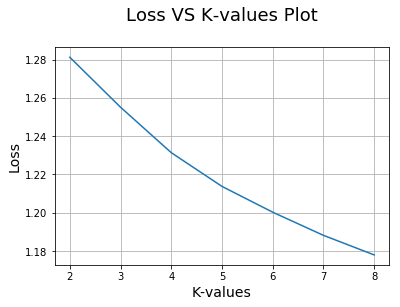

In [61]:
# Draw Loss VS K values plot
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [62]:
optimal_k = 5
# Variable that will be used in the conclusion 
tfidf_w2v_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(tfidf_sent_vectors)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  545

No. of reviews in Cluster-2 :  350

No. of reviews in Cluster-3 :  3106

No. of reviews in Cluster-4 :  3221


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

Total number of review in cluster 1 is: 545


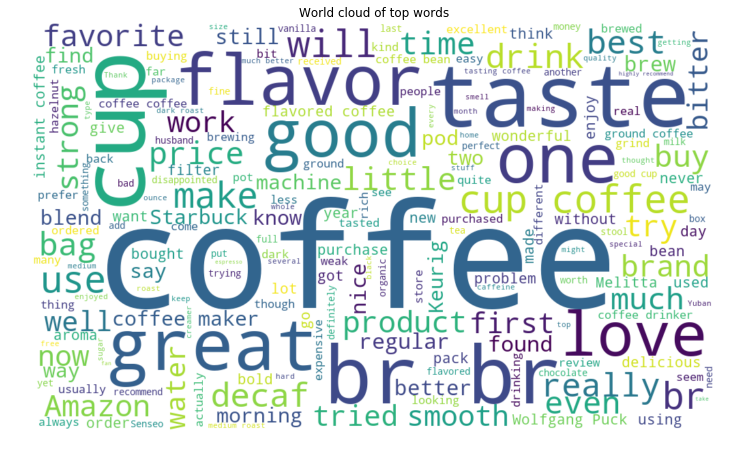

Total number of review in cluster 2 is: 350


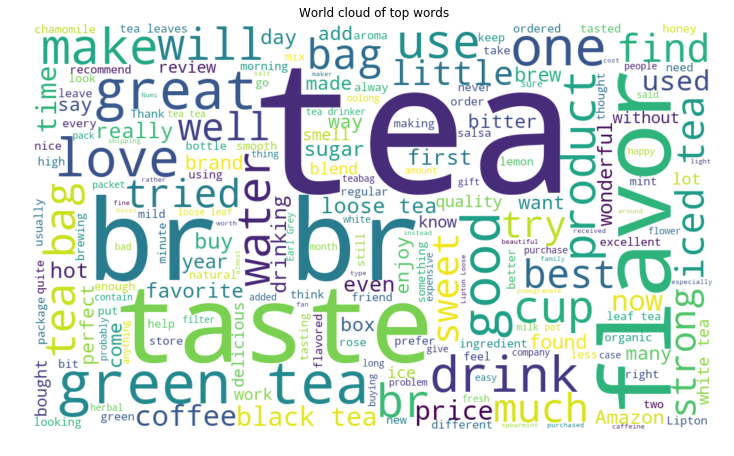

Total number of review in cluster 3 is: 3106


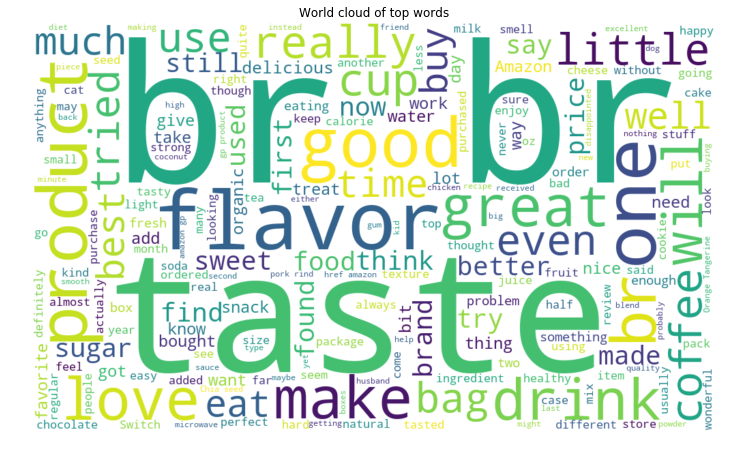

Total number of review in cluster 4 is: 3221


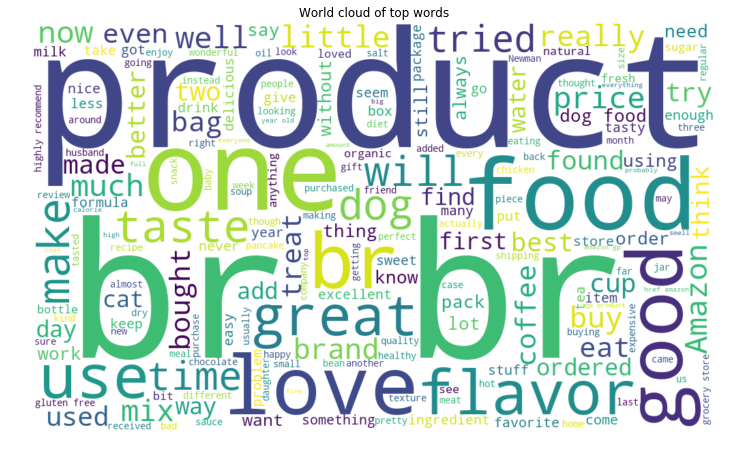

Total number of review in cluster 5 is: 2342


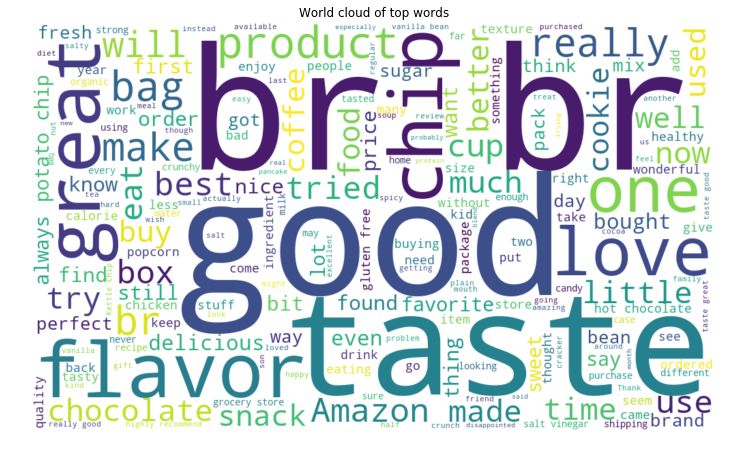

In [65]:
final["cluster_label"] = kmeans.labels_
final["CleanedText"] = preprocessed_reviews

# For each cluster, group with its corresponding label.
for i in range(kmeans.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
   
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["CleanedText"])
    print("Total number of review in cluster {} is: {}".format(i+1, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

#### Agglomerative Clustering with 2 clusters

In [91]:
model = AgglomerativeClustering(n_clusters=2).fit(sent_vectors)

reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  2292

No. of reviews in Cluster-2 :  7272


#### Agglomerative Clustering using 5 clusters

In [93]:
model = AgglomerativeClustering(n_clusters=5).fit(sent_vectors)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  1532

No. of reviews in Cluster-2 :  1259

No. of reviews in Cluster-3 :  718

No. of reviews in Cluster-4 :  1574

No. of reviews in Cluster-5 :  4481


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

#### WordClouds for two clusters obtained using agglomerative clustering.

Total number of review in cluster 1 is: 2292


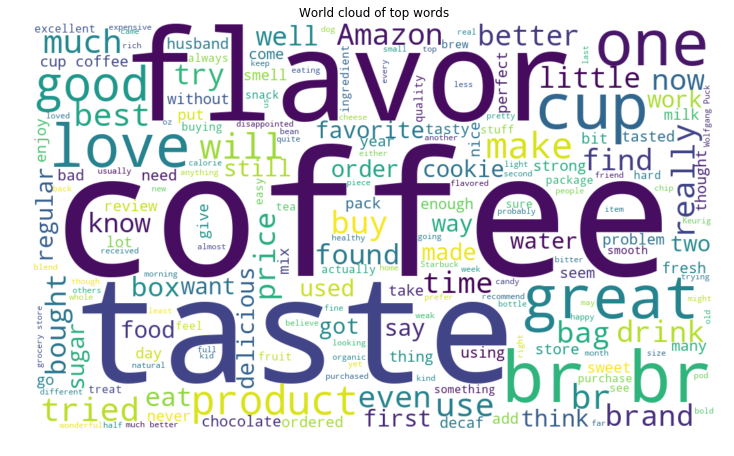

Total number of review in cluster 2 is: 7272


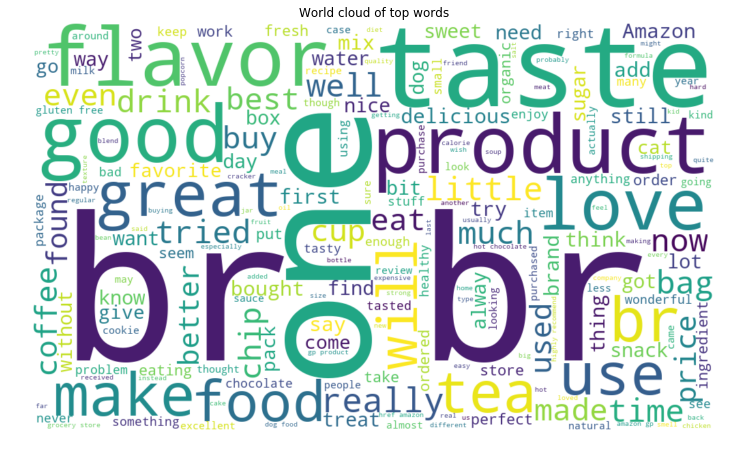

In [92]:
final["cluster_label"] = model.labels_
# For each cluster, group with its corresponding label.
for i in range(model.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
   
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i+1, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

#### WordClouds for 5 clusters obtained using Agglomerative Clustering

Total number of review in cluster 1 is: 1532


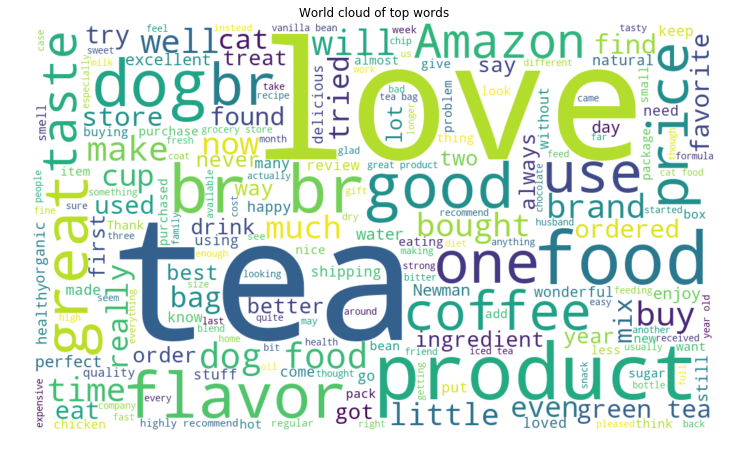

Total number of review in cluster 2 is: 1259


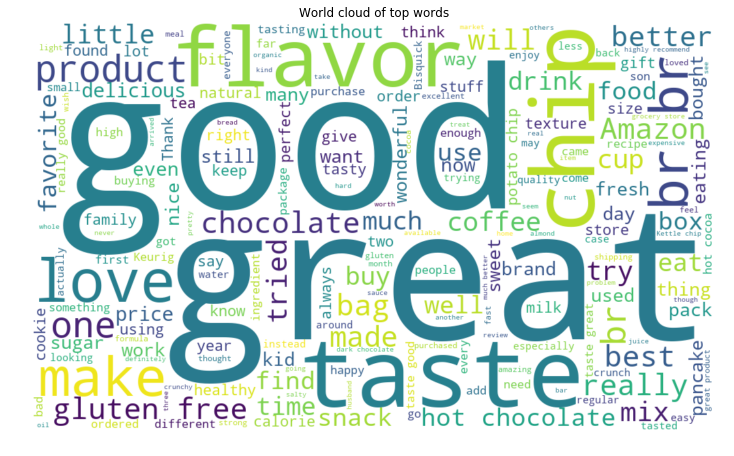

Total number of review in cluster 3 is: 718


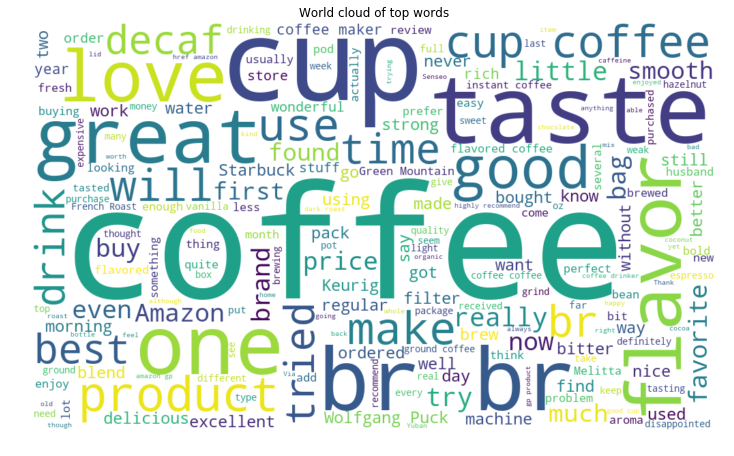

Total number of review in cluster 4 is: 1574


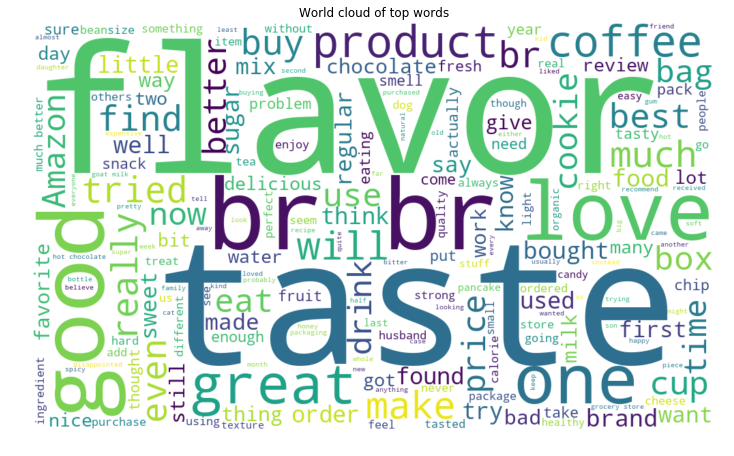

Total number of review in cluster 5 is: 4481


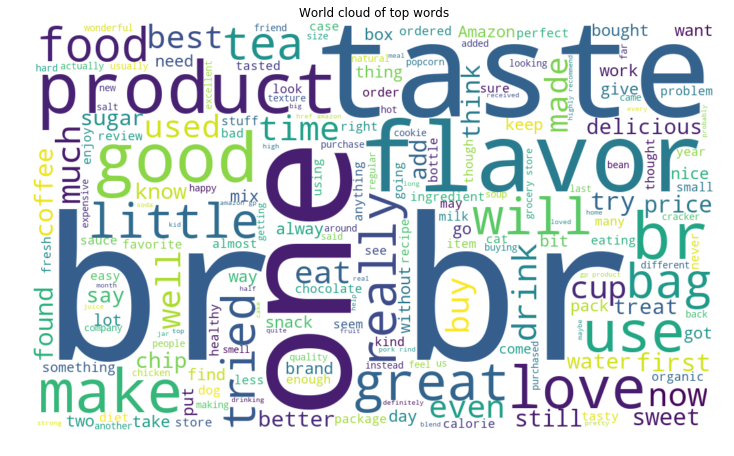

In [94]:
final["cluster_label"] = model.labels_
# For each cluster, group with its corresponding label.
for i in range(model.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
   
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i+1, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

#### Agglomerative Clustering using 2 clusters on TF-IDF w2v

In [121]:
model = AgglomerativeClustering(n_clusters=2).fit(tfidf_sent_vectors)

reviews = final['CleanedText'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  9091

No. of reviews in Cluster-2 :  473


#### Agglomerative Clustering using 5 clusters

In [119]:
model = AgglomerativeClustering(n_clusters=5).fit(tfidf_sent_vectors)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  5155

No. of reviews in Cluster-2 :  3544

No. of reviews in Cluster-3 :  273

No. of reviews in Cluster-4 :  119

No. of reviews in Cluster-5 :  473


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

#### WordCluds for 2 cluster obtained using Agglomerative Clusters

Total number of review in cluster 1 is: 9091


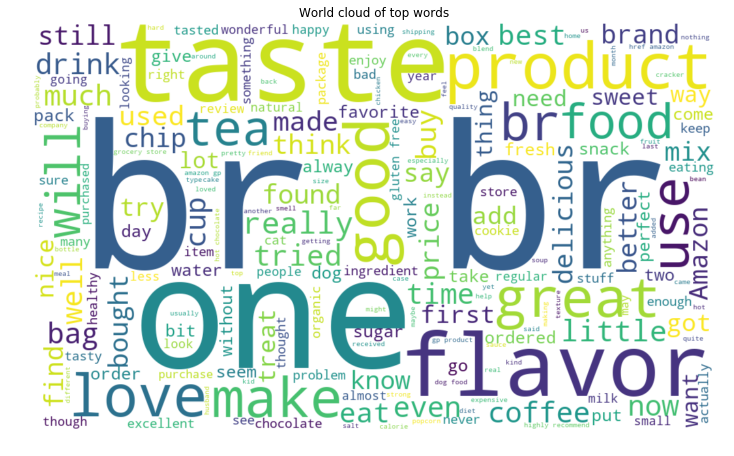

Total number of review in cluster 2 is: 473


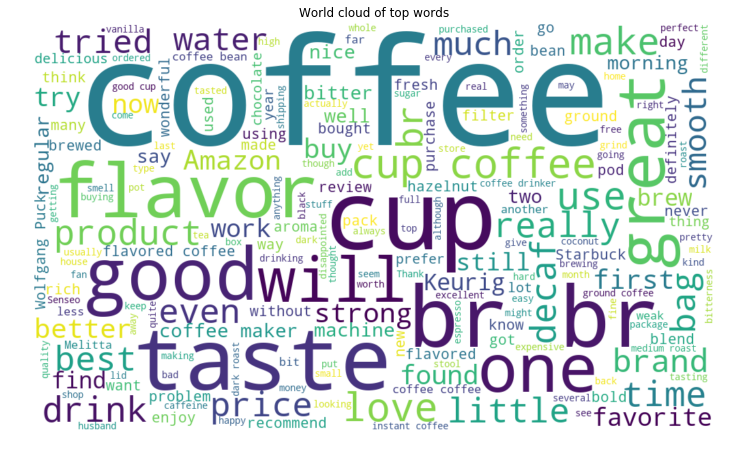

In [122]:
final["cluster_label"] = model.labels_
# For each cluster, group with its corresponding label.
for i in range(model.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
   
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i+1, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

#### WordClouds for 5 clusters obtained using Agglomerative Clustering

Total number of review in cluster 1 is: 5155


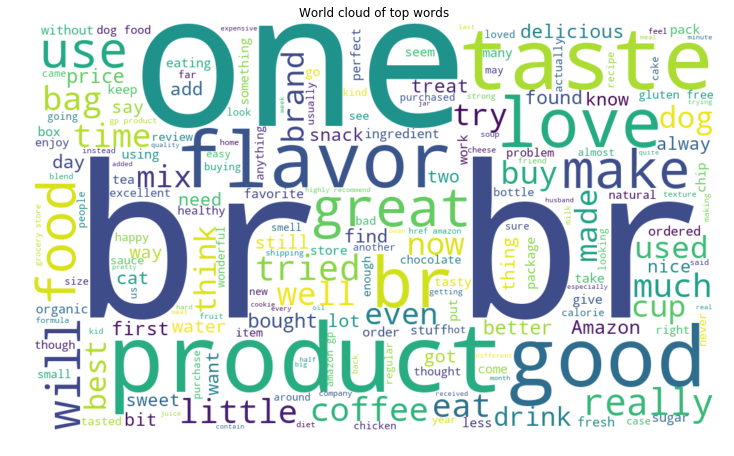

Total number of review in cluster 2 is: 3544


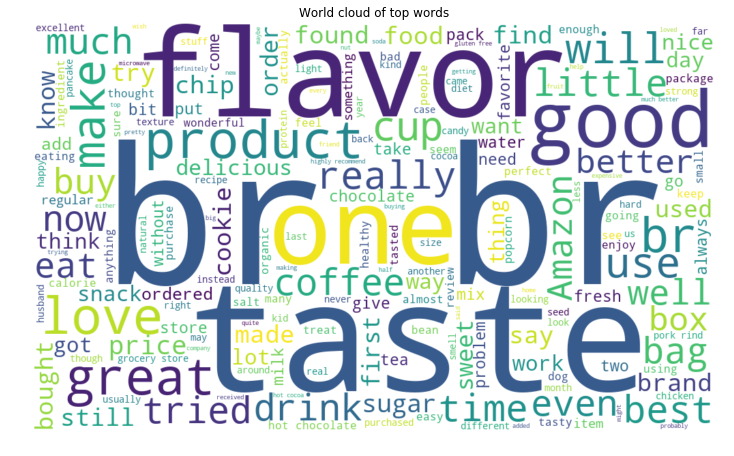

Total number of review in cluster 3 is: 273


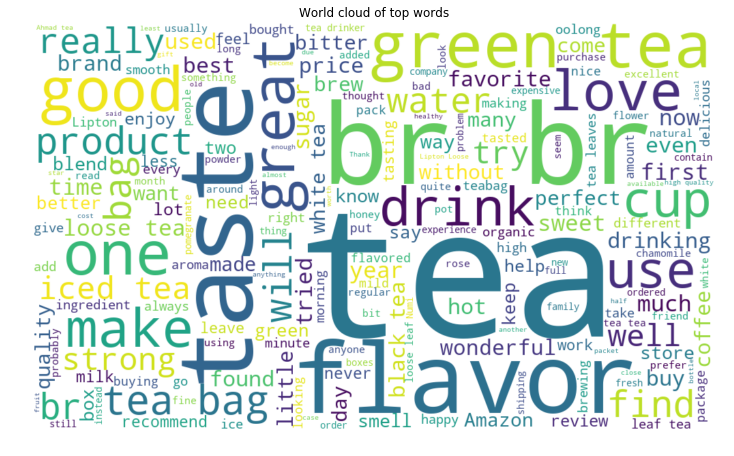

Total number of review in cluster 4 is: 119


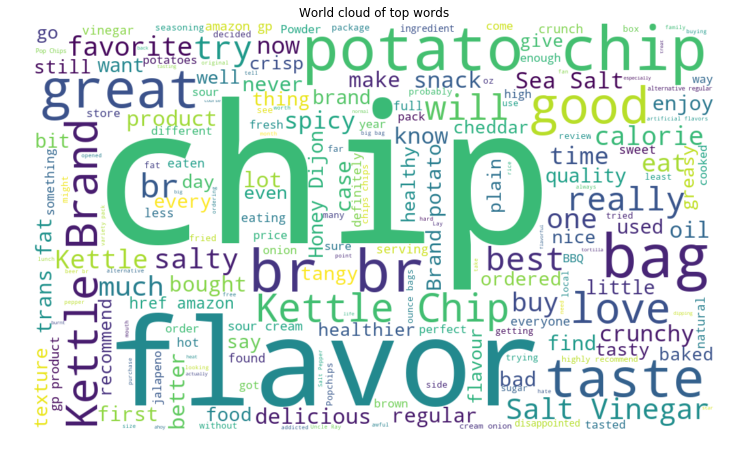

Total number of review in cluster 5 is: 473


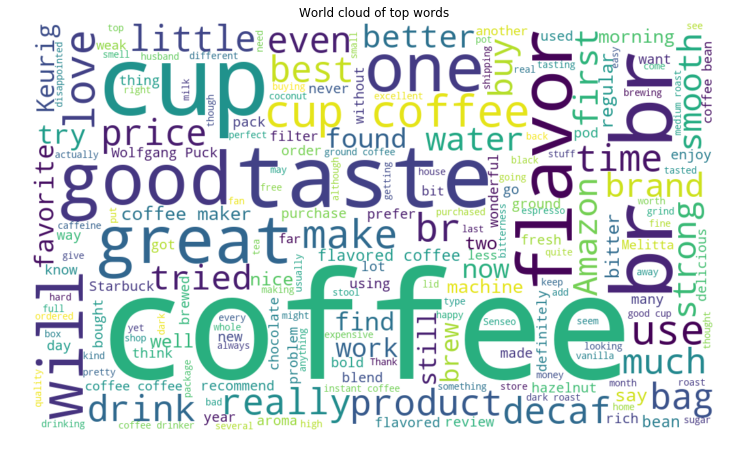

In [120]:
final["cluster_label"] = model.labels_
# For each cluster, group with its corresponding label.
for i in range(model.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
   
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["Text"])
    print("Total number of review in cluster {} is: {}".format(i+1, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

### Function To Compute Distance of nth-nearesr neighbour

In [ ]:
# https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Apply%20DBSCAN%20on%20Amazon%20Fine%20Food%20Reviews.ipynb

In [30]:
# function to determinethe distance of nth-nearest neighbour to all points in a multi-dimensional array
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))    

### Function To Compute Distance of nth-nearesr neighbour

In [31]:
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

Elbow Knee method to find right epsilon

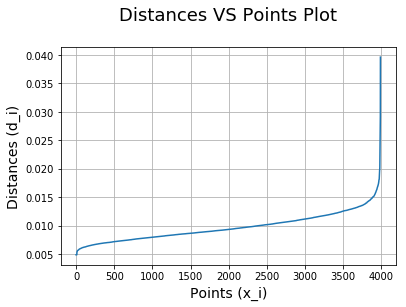

In [32]:
min_points = 2*sent_vectors.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(sent_vectors,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(sent_vectors.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 13 because after that there is sharp rise in the value of distances (d_i's)

### DBSCAN Implementation

In [33]:
optimal_eps = 13
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, sent_vectors)


# Clustering with  epsilon = 14
db2 = dbscan(14, min_points, sent_vectors)


# Clustering with epsilon = 15
db3 = dbscan(15, min_points, sent_vectors)


# Clustering with epsilon = 16
db4 = dbscan(16, min_points, sent_vectors)

Number of clusters for MinPts = 100 and Epsilon = 13.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 14.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 15.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 16.000000 is : 1 
Labels(-1 is for Noise) :  {0}



### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [40]:
dbscan_aw2v_best = DBSCAN(eps=13, n_jobs=-1)
dbscan_aw2v_best = dbscan_aw2v_best.fit(sent_vectors)

In [53]:
reviews = final['Text'].values
cluster = []
for i in range(dbscan_aw2v_best.labels_.shape[0]):
    if dbscan_aw2v_best.labels_[i] == 0:
        if dbscan_aw2v_best.labels_[i] != 'br':
            cluster.append(reviews[i])

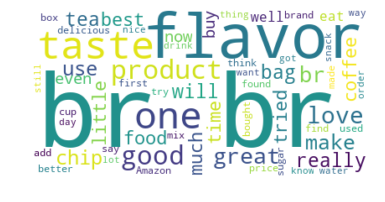

In [54]:
text = str(cluster)
wordcloud = WordCloud(max_font_size=120, max_words=60, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

Elbow Knee method for finding best Epsilon

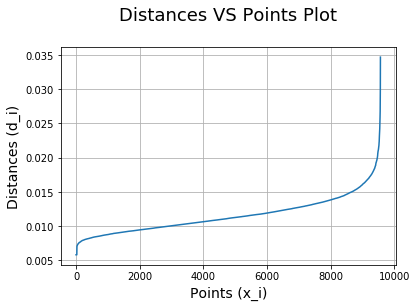

In [104]:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
min_points = 2*tfidf_sent_vectors.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(tfidf_sent_vectors,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(tfidf_sent_vectors.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

OBSERVATION :- From above we can see that the right value of Epsilon is 14 because after that there is sharp rise in the value of distances (d_i's)

## DBSCAN Implementation

In [106]:
optimal_eps = 14
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points, tfidf_sent_vectors)


# Clustering with  epsilon = 15
db2 = dbscan(15, min_points, tfidf_sent_vectors)


# Clustering with epsilon = 16
db3 = dbscan(16, min_points, tfidf_sent_vectors)


# Clustering with epsilon = 17
db4 = dbscan(17, min_points, tfidf_sent_vectors)

Number of clusters for MinPts = 100 and Epsilon = 14.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 15.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 16.000000 is : 1 
Labels(-1 is for Noise) :  {0}

Number of clusters for MinPts = 100 and Epsilon = 17.000000 is : 1 
Labels(-1 is for Noise) :  {0}



### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [48]:
dbscan_tfw2v_best = DBSCAN(eps=14, n_jobs=-1)
dbscan_tf2v_best = dbscan_tfw2v_best.fit(tfidf_sent_vectors)

In [49]:
reviews = final['Text'].values
cluster2 = []
for i in range(dbscan_tfw2v_best.labels_.shape[0]):
    if dbscan_tfw2v_best.labels_[i] == 0:
        cluster2.append(reviews[i])

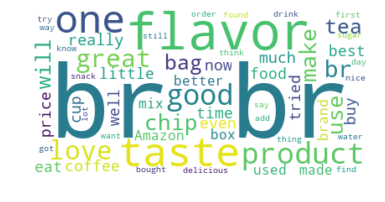

In [51]:
text = str(cluster)
wordcloud = WordCloud(max_font_size=120, max_words=60, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

One thing we can observe from this wordcloud that we have collected data about food items, as here we are getting words like coffee, delicious, flavour, tea, may be this is data about various beverages.

# [6] Conclusions

## 1. For K-Means

In [72]:
# Creating table using PrettyTable library


names = ['K-means for BoW','K-means for TFIDF','K-means for Avg_Word2Vec','K-means for tfidf_Word2Vec']
optimal_k = [bow_means_k,tf_means_k,avg_w2v_means_k,tfidf_w2v_means_k]
numbering = [1,2,3,4]

# Initializing prettytable
table = PrettyTable()
# Adding columns
table.add_column("S.NO.",numbering)
table.add_column("MODEL",names)
table.add_column("Number of Clusters ",optimal_k)

# Printing the Table
print(table)

+-------+----------------------------+---------------------+
| S.NO. |           MODEL            | Number of Clusters  |
+-------+----------------------------+---------------------+
|   1   |      K-means for BoW       |          5          |
|   2   |     K-means for TFIDF      |          6          |
|   3   |  K-means for Avg_Word2Vec  |          4          |
|   4   | K-means for tfidf_Word2Vec |          5          |
+-------+----------------------------+---------------------+


## 2. For aglomerative clustering

In [56]:
number  = [1,2]
cluster = ["Agglomerative", "Agglomerative"]
model   = ["Average w2v", "Tfidf w2v"]
n_cluster = ["2,5", "2,5"]

#Initialize Prettytable
pt = PrettyTable()
pt.add_column("Index", number)
pt.add_column("Clustering", cluster)
pt.add_column("Model", model)
pt.add_column("n_clusters", n_cluster)
print(pt)

+-------+---------------+-------------+------------+
| Index |   Clustering  |    Model    | n_clusters |
+-------+---------------+-------------+------------+
|   1   | Agglomerative | Average w2v |    2,5     |
|   2   | Agglomerative |  Tfidf w2v  |    2,5     |
+-------+---------------+-------------+------------+


## 3. For DBSCAN 

In [3]:
number = [1,2]
cluster= ["DBSCAN", "DBSCAN"]
mode  l= ["Average w2v", "Tfidf w2v"]
eps    = ["13", "14"]

#Initialize Prettytable
pt = PrettyTable()
pt.add_column("Index", number)
pt.add_column("Clustering", cluster)
pt.add_column("Model", model)
pt.add_column("Best eps", eps)
print(pt)

+-------+------------+-------------+----------+
| Index | Clustering |    Model    | Best eps |
+-------+------------+-------------+----------+
|   1   |   DBSCAN   | Average w2v |    13    |
|   2   |   DBSCAN   |  Tfidf w2v  |    14    |
+-------+------------+-------------+----------+
